<p align="Top">Осипов Алексей</p>

<h1 align="center">Аналитика данных. Домашнее задание 2 (HW) Тенисные партии</h1>
<p align="center">Проверить, как изменился мир тенниса за последнее время. Применяйте только данные из одиночного разряда (файлы в формате «atp_matches_YYYY.csv»). Желательно сопровождать выбранный статистический тест ссылкой на его документацию и указывать нулевую гипотезу, которую этот тест проверяет. Далеко не всегда это очевидно.</p>

Подробное описание смотри в readme.md

## План работы по каждой задаче
- Шаг 1: Подготовка данных
    - Загрузка данных
    - Оценка качества данных (Пропуски и дубликаты)
    - Очистка данных
  
- Шаг 2: Формулирование гипотез
    - Нулевая гипотеза
    - Альтернативная гипотеза

- Шаг 3: Определение характеристик выборки
    - Размер, среднее, дисперсия и тд

- Шаг 4: Определение подходящих тестов
    - Обоснование выбора теста
    - Проведение теста
    - Принятие или отклонение нулевой гипотезы

- Шаг 5: Формулирование выводов


## Импорт

In [4]:
# Импорты библиотек для проекта
import requests
from bs4 import BeautifulSoup
import re

import os
import glob

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm # для qq plot

from scipy.stats import shapiro # тест на нормальность распределения Шапиро
from scipy.stats import normaltest # тест на нормальность распределения Деагостино
from scipy.stats import mannwhitneyu # тест Манна-Уитни непараметрический тест
from scipy.stats import ttest_ind # t-тест
from statsmodels.stats.weightstats import ztest # z-тест
from scipy.stats import kruskal 
from scipy import stats # библиотека для расчетов
from statsmodels.stats.proportion import proportions_ztest
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Подготовка данных для всех задач

Скачиваем данные из github.com и помещаем в папку на своем гигхабе.

In [8]:
# Сборка датасетов в датафрейм

# Указываем путь к папке с данными
folder_path = 'github_data'  # Укажи актуальный путь

# Получаем список всех CSV файлов, соответствующих маске 'atp_matches_*.csv'
csv_files = glob.glob(os.path.join(folder_path, 'atp_matches_*.csv'))

# Читаем каждый CSV файл и добавляем его в список датафреймов
df_list = [pd.read_csv(file) for file in csv_files]

# Объединяем все датафреймы в один, игнорируя индексы и используя внешнее объединение
combined_df = pd.concat(df_list, ignore_index=True, join='outer')

# Извлекаем год из столбца tourney_id и преобразуем его в целочисленный тип
combined_df['year'] = combined_df['tourney_id'].str.extract(r'(\d{4})').astype(int)

# Сохраняем объединенный датафрейм в файл 'full_data/combined_atp_matches.csv' без индексов
combined_df.to_csv('full_data/combined_atp_matches.csv', index=False)

In [22]:
#combined_df = pd.read_csv('full_data/combined_atp_matches.csv')

In [24]:
combined_df = pd.read_csv('combined_df.csv')

In [25]:
combined_df.shape

(191920, 50)

In [ ]:
# Создаем пустой DataFrame
combined_df = pd.DataFrame()

# Указываем папку, в которой находятся файлы
folder_path = "full_data"

# Проходим по всем файлам в указанной папке
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):  # Проверяем, что файл имеет расширение .csv
        file_path = os.path.join(folder_path, file_name)
        
# Загружаем данные из файла в DataFrame
data = pd.read_csv(file_path)
        
# Добавляем данные из файла в общий DataFrame
combined_df = pd.concat([combined_df, data], ignore_index=True)
 # Извлекаем год из столбца tourney_id и преобразуем его в целочисленный тип
combined_df['year'] = combined_df['tourney_id'].str.extract(r'(\d{4})').astype(int)
# Сохраняем объединенный датафрейм в файл 'full_data/combined_atp_matches.csv' без индексов
combined_df.to_csv('combined_df.csv', index=False)

### Функции для предобработки

In [59]:
def dataframe_info(dataframe):
    """
    Функция для получения информации о датафрейме.
    """
        
    # Вывод общей информации о датафрейме
    print("Информация о датафрейме:")
    display(dataframe.info())
    
    # Вывод статистической информации о числовых столбцах
    print("\nСтатистика по числовым столбцам:")
    display(dataframe.describe())
    
    # Вывод информации о пропущенных значениях
    print("\nПропущенные значения:")
    print(dataframe.isnull().sum())
    
    # Вывод первых 5 строк датафрейма
    print("\nПервые 5 строк датафрейма:")
    display(dataframe.head())

In [55]:
def uninformative_features(df):
    """
    Функция для определения неинформативных признаков в датафрейме.
    
    Признаки считаются неинформативными, если одно значение встречается более чем в 95%
    случаев или если более 95% значений являются уникальными.
     
    """
    
    uninformative_features = []
    
    for column in df.columns:
        if df[column].nunique() == 1 or df[column].nunique() / df[column].count() > 0.95:
            uninformative_features.append(column)
    
    if len(uninformative_features) > 0:
        return uninformative_features
    else:
        return "Неинформативных особенностей не обнаружено."

In [8]:
def plot_missing_values(df):
    """
    Функция для построения столбчатой диаграммы, отображающей процент пропущенных значений в каждом столбце датафрейма.
   
    """
    def plot_missing_values(df):
    missing_values = df.isnull().mean().sort_values() * 100
    ax = missing_values.plot(kind='bar', figsize=(10, 6), color='skyblue', edgecolor='black')
    ax.set_title('Пропуски в процентах')
    plt.xticks(rotation=90)
    plt.show()

### Функции для графического описаниея распределений признака для каждой выборки

In [126]:
#Проверить работу когда дойдет очередь!
"""
    Функция для создания графиков QQ, гистограмм и boxplot для двух выборок.
"""

def plot_comparison(sample_data_a, sample_data_b, title_a='a', title_b='b'):
    # QQ plot
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    stats.probplot(sample_data_a, dist="norm", plot=plt)
    plt.title(f'QQ Plot for {title_a}')

    plt.subplot(1, 3, 2)
    plt.hist(sample_data_a, bins=10, color='skyblue', edgecolor='black')
    plt.title(f'Histogram for {title_a}')

    plt.subplot(1, 3, 3)
    plt.boxplot(sample_data_a)
    plt.title(f'Boxplot for {title_a}')

    plt.show()

    # QQ plot
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    stats.probplot(sample_data_b, dist="norm", plot=plt)
    plt.title(f'QQ Plot for {title_b}')

    plt.subplot(1, 3, 2)
    plt.hist(sample_data_b, bins=10, color='salmon', edgecolor='black')
    plt.title(f'Histogram for {title_b}')

    plt.subplot(1, 3, 3)
    plt.boxplot(sample_data_b)
    plt.title(f'Boxplot for {title_b}')

    plt.show()

# Пример использования
#sample_data_a = np.random.normal(loc=0, scale=1, size=100)
#sample_data_b = np.random.normal(loc=0, scale=1, size=100)
#plot_comparison(sample_data_a, sample_data_b, 'Sample A', 'Sample B')

### Тест Шапиро на нормальность

In [141]:
def shapiro_test(sample_a, sample_b, alpha=0.05):
    H0 = 'Распределения в обеих группах нормальные'
    H1 = 'Распределение в одной или обеих группах отлично от нормального'

    shapiro_result_a = shapiro(sample_a)
    shapiro_result_b = shapiro(sample_b)

    print(f'alpha: {alpha}')
    print('p-value sample A', round(shapiro_result_a.pvalue, 2))
    print('p-value sample B', round(shapiro_result_b.pvalue, 2))

    if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
        print("Отвергаем нулевую гипотезу H0: {}".format(H0))
        print("Альтернативная гипотеза. H1: {}".format(H1))
    else:
        print("Принимаем нулевую гипотезу. {}".format(H0))

# Пример использования:
# shapiro_test(more20['deviation'], less20['deviation'], alpha=0.05)

## Предобработка для всех задач

### Неинформативные признаки

In [56]:
uninformative_features(combined_df)

'Неинформативных особенностей не обнаружено.'

### Пропуски

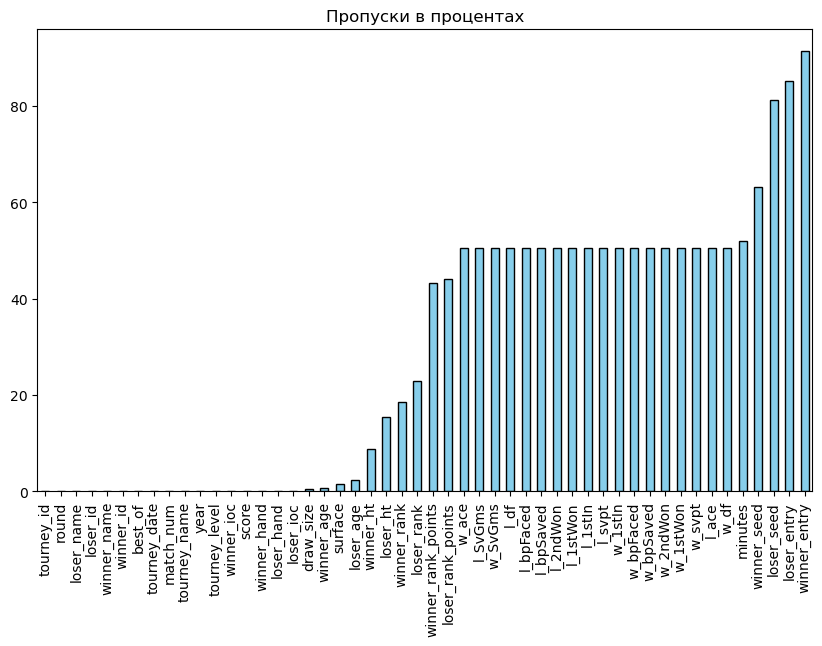

In [58]:
plot_missing_values(combined_df)

In [65]:
# удаляем столбец если у него 60% или более значений отсутствует
combined_df = combined_df.dropna(axis=1, thresh=(0.4 * combined_df.shape[0]))

In [66]:
# Общий обзор сборного датасета
dataframe_info(combined_df)

Информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191920 entries, 0 to 191919
Data columns (total 46 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   tourney_id          191920 non-null  object 
 1   tourney_name        191920 non-null  object 
 2   surface             188930 non-null  object 
 3   draw_size           191085 non-null  float64
 4   tourney_level       191920 non-null  object 
 5   tourney_date        191920 non-null  int64  
 6   match_num           191920 non-null  int64  
 7   winner_id           191920 non-null  int64  
 8   winner_name         191920 non-null  object 
 9   winner_hand         191908 non-null  object 
 10  winner_ht           175012 non-null  float64
 11  winner_ioc          191912 non-null  object 
 12  winner_age          190609 non-null  float64
 13  loser_id            191920 non-null  int64  
 14  loser_name          191920 non-null  object 
 15  loser_han

None


Статистика по числовым столбцам:


,draw_size,tourney_date,match_num,winner_id,winner_ht,winner_age,loser_id,loser_ht,loser_age,best_of,...,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,year
count,191085.000000,1.919200e+05,191920.000000,191920.000000,175012.000000,190609.000000,191920.000000,162257.000000,187263.000000,191920.000000,...,95034.000000,95034.000000,95035.000000,95034.000000,95034.000000,156159.000000,108936.000000,147788.000000,107308.000000,191920.000000
mean,53.088479,1.993711e+07,79.398656,104499.014537,184.491618,25.670153,105686.966012,184.261696,25.721450,3.437755,...,31.962361,14.972936,12.206229,4.808942,8.730570,75.246960,1375.909663,112.905710,865.976908,1993.656216
std,36.645414,1.581156e+05,111.963129,13664.799449,6.672384,4.053105,16655.971639,6.658745,4.198698,0.827880,...,14.447415,7.207299,4.131171,3.275134,4.132557,120.956559,1729.720178,162.603579,993.837316,15.814683
min,2.000000,1.967123e+07,1.000000,100001.000000,160.000000,14.300000,100001.000000,160.000000,14.200000,1.000000,...,0.000000,0.000000,0.000000,-6.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1968.000000
25%,32.000000,1.980051e+07,11.000000,100417.000000,180.000000,22.700000,100523.000000,180.000000,22.700000,3.000000,...,22.000000,10.000000,9.000000,2.000000,6.000000,17.000000,494.000000,37.000000,365.000000,1980.000000
50%,32.000000,1.993052e+07,25.000000,101733.000000,185.000000,25.300000,101900.000000,185.000000,25.300000,3.000000,...,30.000000,14.000000,11.000000,4.000000,8.000000,45.000000,850.000000,70.000000,635.000000,1993.000000
75%,64.000000,2.007032e+07,94.000000,103990.000000,188.000000,28.200000,104338.000000,188.000000,28.400000,3.000000,...,40.000000,19.000000,15.000000,7.000000,11.000000,86.000000,1540.000000,118.000000,1015.000000,2007.000000
max,128.000000,2.023113e+07,1701.000000,212428.000000,211.000000,58.700000,212437.000000,211.000000,63.600000,5.000000,...,284.000000,101.000000,91.000000,28.000000,38.000000,2101.000000,16950.000000,2159.000000,16950.000000,2023.000000



Пропущенные значения:
tourney_id                0
tourney_name              0
surface                2990
draw_size               835
tourney_level             0
tourney_date              0
match_num                 0
winner_id                 0
winner_name               0
winner_hand              12
winner_ht             16908
winner_ioc                8
winner_age             1311
loser_id                  0
loser_name                0
loser_hand               49
loser_ht              29663
loser_ioc                72
loser_age              4657
score                     9
best_of                   0
round                     0
minutes               99653
w_ace                 96885
w_df                  96886
w_svpt                96886
w_1stIn               96886
w_1stWon              96886
w_2ndWon              96886
w_SvGms               96885
w_bpSaved             96886
w_bpFaced             96886
l_ace                 96886
l_df                  96885
l_svpt                968

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_name,winner_hand,...,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,year
0,1968-2029,Dublin,Grass,32.0,A,19680708,270,112411,Doug Smith,U,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1968
1,1968-2029,Dublin,Grass,32.0,A,19680708,271,126914,Louis Pretorius,R,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1968
2,1968-2029,Dublin,Grass,32.0,A,19680708,272,209523,Cecil Pedlow,U,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1968
3,1968-2029,Dublin,Grass,32.0,A,19680708,273,100084,Tom Okker,R,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1968
4,1968-2029,Dublin,Grass,32.0,A,19680708,274,100132,Armistead Neely,R,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1968


## 1. Мы хотим узнать, как много значит ранг игрока в теннисе. 
## Проверяем следующие утверждения

а) Если ранг игрока выше более, чем на 20 позиций, то в среднем он будет выигрывать с большей вероятностью. (Если хотите проверить статистически — формируйте выборку как отклонение от ожидаемого количества побед при случайном исходе);

>Для проверки данного утверждения мы можем воспользоваться t-тестом для независимых выборок. Нулевая гипотеза, которую мы будем проверять, состоит в том, что нет статистически значимой разницы в средних значениях побед игроков, чей ранг отличается более, чем на 20 позиций.

Шаги для проведения теста:

* Сформируем две выборки игроков: одна с разницей в ранге более, чем на 20 позиций, и другая - с разницей менее или равной 20 позициям.
* Посчитаем среднее количество выигранных матчей в каждой из выборок.
* Проведем t-тест для сравнения средних значений.
* Если результаты теста показывают статистически значимую разницу в средних значениях побед между игроками с высоким и низким рангом, то утверждение о том, что игрок с более высоким рангом выигрывает с большей вероятностью, будет подтверждено.

б) Если ранг игрока находится в окне +-5 позиций, то вероятность победы будет значительно отличаться от гипотезы из предыдущего случая. Для проверки статистической значимости выборку можно сделать как среднее по годам (например, с 1980 по 2022г.). Подумайте, как правильно сформировать репрезентативную выборку.

>Для проверки статистической значимости разницы в вероятности победы игроков, чьи ранги находятся в окне +/- 5 позиций, относительно гипотезы из предыдущего случая, необходимо сформировать репрезентативную выборку. Одним из способов сделать это может быть группировка данных по годам (например, с 1980 по 2022 год) и вычисление средней вероятности побед для игроков с рангами в окне +/- 5 позиций в каждом году.

Процесс формирования репрезентативной выборки может выглядеть следующим образом:

* Отфильтровать данные, чтобы оставить только информацию о матчах, в которых участвовали игроки с рангами, отличающимися не более чем на 5 позиций.
* Сгруппировать данные по годам.
* Для каждого года рассчитать среднюю вероятность победы игроков с рангами в окне +/- 5 позиций.
* Таким образом можно сравнить средние вероятности побед для игроков из окна +/- 5 позиций с общей вероятностью побед, рассчитанной в предыдущем случае, и определить статистическую значимость различий.

## а) Если ранг игрока выше более, чем на 20 позиций

In [133]:
# Формируем две выборки игроков: с разницей в ранге более, чем на 20 позиций, и менее или равной 20 позициям
sample_01 = combined_df[['year', 'match_num', 'winner_id', 'winner_rank', 'loser_id', 'loser_rank']].dropna()
sample_01['rank_diff_more20'] = np.where(abs(sample_01['winner_rank'] - sample_01['loser_rank']) > 20, 1, 0)

high_rank_players = sample_01[sample_01['winner_rank'] - sample_01['loser_rank'] > 20]
low_rank_players = sample_01[sample_01['winner_rank'] - sample_01['loser_rank'] <= 20]

# Считаем среднее количество выигранных матчей в каждой выборке
mean_high_ranks_wins = np.mean(high_rank_players['winner_rank'])
mean_low_ranks_wins = np.mean(low_rank_players['winner_rank'])

# Проводим t-тест
t_stat, p_val = ttest_ind(high_rank_players['winner_rank'], low_rank_players['winner_rank'])

# Вывод результатов теста
print("Среднее количество побед у игроков с высоким рангом:", mean_high_ranks_wins)
print("Среднее количество побед у игроков с низким рангом:", mean_low_ranks_wins)
print(f"t-statistic: {t_stat}, p-value: {p_val}")



# Выводим результаты
if p_val < 0.05:
    print("Есть статистически значимая разница в среднем количестве побед между игроками с высоким и низким рангом")
    if mean_high_ranks_wins > mean_low_ranks_wins:
        print("Утверждение о том, что игрок с более высоким рангом выигрывает с большей вероятностью, подтверждено")
    else:
        print("Утверждение о том, что игрок с более высоким рангом выигрывает с большей вероятностью, не подтверждено")
else:
    print("Нет статистически значимой разницы в среднем количестве побед между игроками с высоким и низким рангом")

Среднее количество побед у игроков с высоким рангом: 149.61979261415317
Среднее количество побед у игроков с низким рангом: 47.882438355670196
t-statistic: 168.40785738991397, p-value: 0.0
Есть статистически значимая разница в среднем количестве побед между игроками с высоким и низким рангом
Утверждение о том, что игрок с более высоким рангом выигрывает с большей вероятностью, подтверждено


## б) Если ранг игрока находится в окне +-5 позиций

In [149]:
sample_01['player_rank'] = (sample_01['winner_rank'] - sample_01['loser_rank'])

# Фильтрация данных для игроков с рангами в окне +/- 5 позиций 
filtered_data = sample_01[(sample_01['player_rank'] >= sample_01['player_rank'] - 5)\
                          & (sample_01['player_rank'] <= sample_01['player_rank'] + 5)\
                          &(sample_01['year'] >= 1984) & (sample_01['year'] <= 2022)]

# Группировка данных по годам и подсчет средней вероятности победы
grouped_data = filtered_data.groupby('year')['winner_rank'].mean()

# Вычисление общей средней вероятности победы
overall_mean = sample_01['winner_rank'].mean()


# Проведение теста на статистическую значимость различий
t_statistic, p_value = stats.ttest_1samp(grouped_data, overall_mean)

print("Среднее количество побед у игроков в окне +/-5:",overall_mean)
print(f"t-statistic: {t_statistic}, p-value: {p_value}")

# Выводим результаты
if p_value < 0.05:
    print("Рзличия являются статистически значимыми.")
else:
    print("Рзличия НЕ являются статистически значимыми.")

Среднее количество побед у игроков в окне +/-5: 71.2072083970527
t-statistic: 3.763241826043754, p-value: 0.0005661744215358327
Рзличия являются статистически значимыми.


### Графическое описание распределений признака

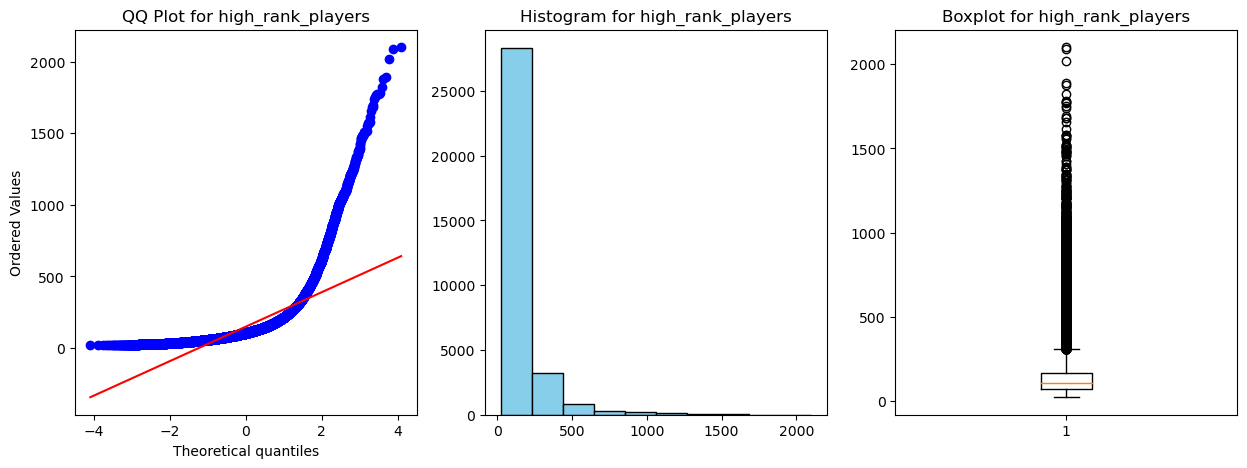

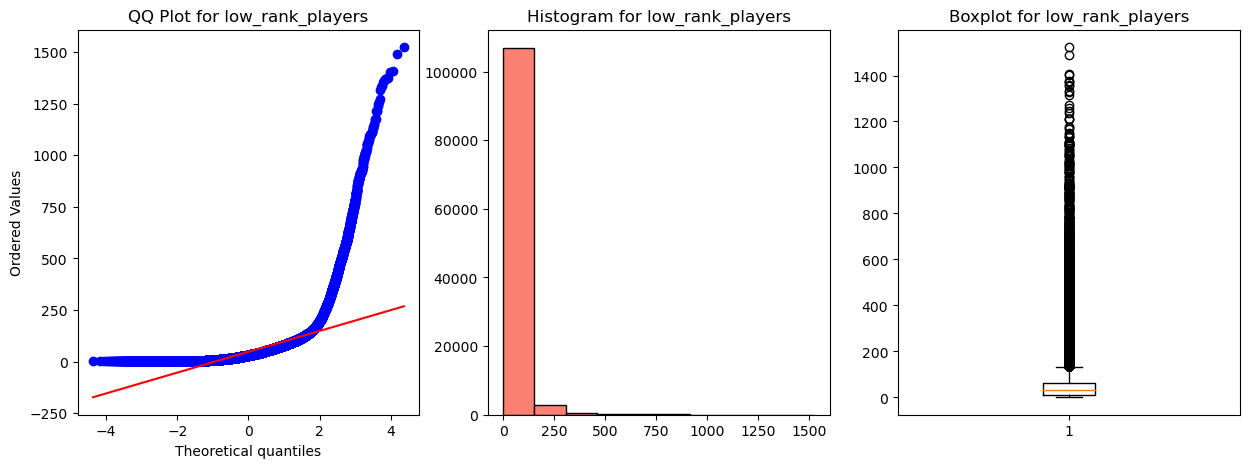

In [150]:
plot_comparison(high_rank_players['winner_rank'], low_rank_players['winner_rank'], title_a='high_rank_players', title_b='low_rank_players')

#### Статистический тест на нормальность

In [142]:
shapiro_test(high_rank_players['winner_rank'], low_rank_players['winner_rank'], alpha=0.05)

alpha: 0.05
p-value sample A 0.0
p-value sample B 0.0
Отвергаем нулевую гипотезу H0: Распределения в обеих группах нормальные
Альтернативная гипотеза. H1: Распределение в одной или обеих группах отлично от нормального


### Вывод:
Если ранг игрока находится в окне +-5 позиций, то вероятность победы будет значительно отличаться (вероятность победы ниже) от гипотезы из предыдущего случая (там разницы нет). Для формирования репрезентативной выборки сделано усредненние побед всех игроков по годам.

## 2. 
>Правда ли, что среднее количество сетов, которое необходимо любому игроку для победы в матче, сокращается со временем? Разбейте данные на две группы — с 1980 до 2001 гг. и 2002-2022 гг. Как изменилось среднее количество сетов, которое победитель затратил на игру? Является ли разница средних этих двух выборок статистически значимой? Выбор статистического теста обоснуйте.

Количество сетов можно рассчитать, используя признак `score`

In [175]:
# Создание выборки к задаче
sample_02 = combined_df[['year', 'score', 'winner_id']].dropna()
# Удаление полных дубликатов
sample_02 = sample_02.drop_duplicates()

def count_sets_with_scores(score):
    sets = re.findall(r'\d+-\d+', score)
    return len(sets)

sample_02['set_count'] = sample_02['score'].apply(count_sets_with_scores)

# Данные по количеству сетов для группы 1 (1980-2001 гг.)
group1_data = sample_02[(sample_02['year'] >= 1980) & (sample_02['year'] <= 2001)].reset_index(drop=True)

# Данные по количеству сетов для группы 2 (2002-2022 гг.)
group2_data = sample_02[(sample_02['year'] >= 2002) & (sample_02['year'] <= 2022)].reset_index(drop=True)

# Вычисляем средние значения для обеих групп
mean_group1 = group1_data.set_count.mean()
mean_group2 = group2_data.set_count.mean()


# Сравнение среднего количества побед
print(f"Среднее количество сетов для побед в периоде 1980-2001: {mean_group1}")
print(f"Общее количество партий: {len(group1_data.set_count)}")
print(f"Среднее количество сетов для побед в периоде 2002-2022: {mean_group2}")
print(f"Общее количество партий: {len(group2_data.set_count)}")

Среднее количество сетов для побед в периоде 1980-2001: 2.6531740125141265
Общее количество партий: 72558
Среднее количество сетов для побед в периоде 2002-2022: 2.6705863907180936
Общее количество партий: 57402


In [157]:
df_info(sample_02)

Количество записей: 	 191911
Количество столбцов: 	 4
Явных дубликатов: 	 17938
Пропуски присутствуют в 0 столбцах из 4:


,Пропущено %


Обобщенная информация:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 191911 entries, 0 to 191919
Columns: 4 entries, year to set_count
dtypes: int64(3), object(1)
memory usage: 7.3+ MB


None

Первые 3 строки:


,year,score,winner_id,set_count
0,1968,6-1 7-5,112411,2
1,1968,6-1 6-1,126914,2
2,1968,6-2 6-2,209523,2


### Графическое описание распределений признака для каждой выборки

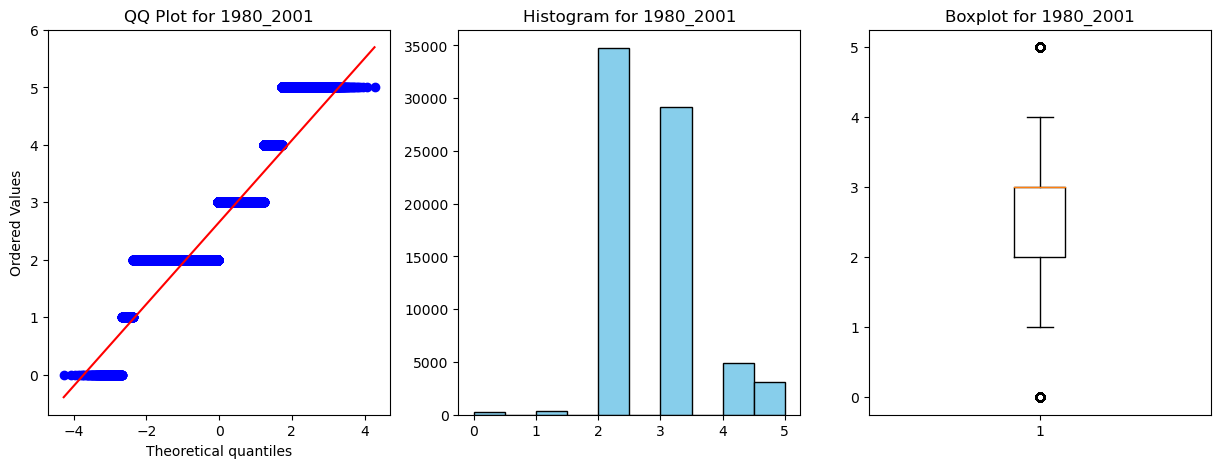

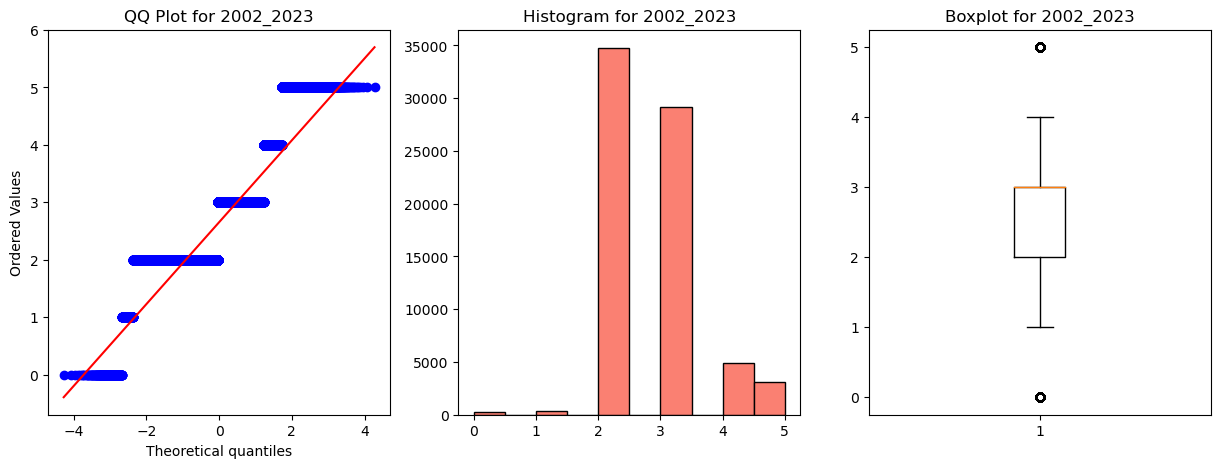

In [169]:
plot_comparison((group1_data.set_count), (group1_data.set_count), title_a='1980_2001', title_b='2002_2022')

### Статистический тест на нормальность

In [170]:
shapiro_test(group1_data.set_count, group2_data.set_count, alpha=0.05)

alpha: 0.05
p-value sample A 0.0
p-value sample B 0.0
Отвергаем нулевую гипотезу H0: Распределения в обеих группах нормальные
Альтернативная гипотеза. H1: Распределение в одной или обеих группах отлично от нормального


> Допустим, что выборки все же нормально распределены, на основании графического представления. Поэтому используем Z-тест.

In [174]:
# Нулевая гипотеза: среднее значение первой выборки меньше или равно среднему значению второй выборки
# Альтернативная гипотеза: среднее значение первой выборки больше среднего значения второй выборки

# Проведем z-тест
z_stat, p_value = ztest(group1_data.set_count, group1_data.set_count, alternative='larger')

print(f'Z-statistic: {z_stat}')
print(f'P-value: {p_value}')

# Установим уровень значимости, например, 0.05
alpha = 0.05

# Проверим нулевую гипотезу
if p_value < alpha:
    print("Отвергаем нулевую гипотезу - есть достаточные доказательства, что среднее первой выборки 1980_2001 больше среднего второй 2002_2023")
else:
    print("Не отвергаем нулевую гипотезу - нет достаточных доказательств считать среднее первой выборки 1980_2001 большим")

Z-statistic: 0.0
P-value: 0.5
Не отвергаем нулевую гипотезу - нет достаточных доказательств считать среднее первой выборки 1980_2001 большим


### Вывод: 

Графическое распределение говорит о нормальном распределении значений количества сетов в выборках.

Проведенный z тест позволяет утверждать - среднее значение первой выборки 1980_2001 меньше или равно среднему значению второй выборки 2002_2023.

Среднее количество сетов для любого игрока чтобы победить уменьшается со временем - не верно.

## 3.

> У вас появились сомнения — не является ли результат, который вы посчитали на предыдущем шаге, некорректным. Кажется, что на это мог повлиять формат самого матча — best of 3 или best of 5. Оставьте только матчи best of 5 (колонка best_of) и определите — является ли разница среднего количества сетов, которое сыграл победитель, значимой для выборок матчей по 1980 до 2001 гг. и 2002-2022 гг. Выбор статистического теста обоснуйте.

Чтобы сформировать датасет надо:
1. Фильтрация данных: Оставить только матчи, где значение в колонке best_of равно 5. Это можно сделать, создав новый фрейм данных, который содержит только строки, где df['best_of'] == 5.
2. Разделение данных на две группы: Разделите данные на две группы в зависимости от года матча. Одна группа должна содержать матчи с 1980 по 2001 год, а другая с 2002 по 2022 год. Это можно сделать с помощью логического индексирования по столбцу с годами.

In [177]:
# Создание выборки к задаче
sample_03 = combined_df[['year', 'score', 'winner_id', 'best_of']].dropna()
# Удаление полных дубликатов
sample_03 = sample_03.drop_duplicates()
# Создаем признак с количеством сетов
sample_03 = sample_03[sample_03.best_of == 5]
def count_sets_with_scores(score):
    sets = re.findall(r'\d+-\d+', score)
    return len(sets)

sample_03['set_count'] = sample_03['score'].apply(count_sets_with_scores)

# Данные по количеству сетов для группы 1 (1980-2001 гг.)
group1_03_data = sample_03[(sample_03['year'] >= 1980) & (sample_03['year'] <= 2001)].reset_index(drop=True)

# Данные по количеству сетов для группы 2 (2002-2022 гг.)
group2_03_data = sample_03[(sample_03['year'] >= 2002) & (sample_03['year'] <= 2022)].reset_index(drop=True)

# Вычисляем средние значения для обеих групп
mean_03_group1 = group1_03_data.set_count.mean()
mean_03_group2 = group2_03_data.set_count.mean()


# Сравнение среднего количества побед
print(f"Среднее количество сетов для побед в периоде 1980-2001: {mean_03_group1}")
print(f"Общее количество партий: {len(group1_03_data.set_count)}")
print(f"Среднее количество сетов для побед в периоде 2002-2022: {mean_03_group1}")
print(f"Общее количество партий: {len(group2_03_data.set_count)}")

Среднее количество сетов для побед в периоде 1980-2001: 3.6685703643925756
Общее количество партий: 16109
Среднее количество сетов для побед в периоде 2002-2022: 3.6685703643925756
Общее количество партий: 14177


In [178]:
df_info(sample_03)

Количество записей: 	 41753
Количество столбцов: 	 5
Явных дубликатов: 	 0
Пропуски присутствуют в 0 столбцах из 5:


,Пропущено %


Обобщенная информация:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 41753 entries, 31 to 191699
Columns: 5 entries, year to set_count
dtypes: int64(4), object(1)
memory usage: 1.9+ MB


None

Первые 3 строки:


,year,score,winner_id,best_of,set_count
31,1968,6-1 6-4 6-4,100029,5,3
32,1968,6-3 6-2 0-6 6-3,100099,5,4
33,1968,11-9 9-11 6-4 6-3,100022,5,4


### Графическое описание распределений признака для каждой выборки

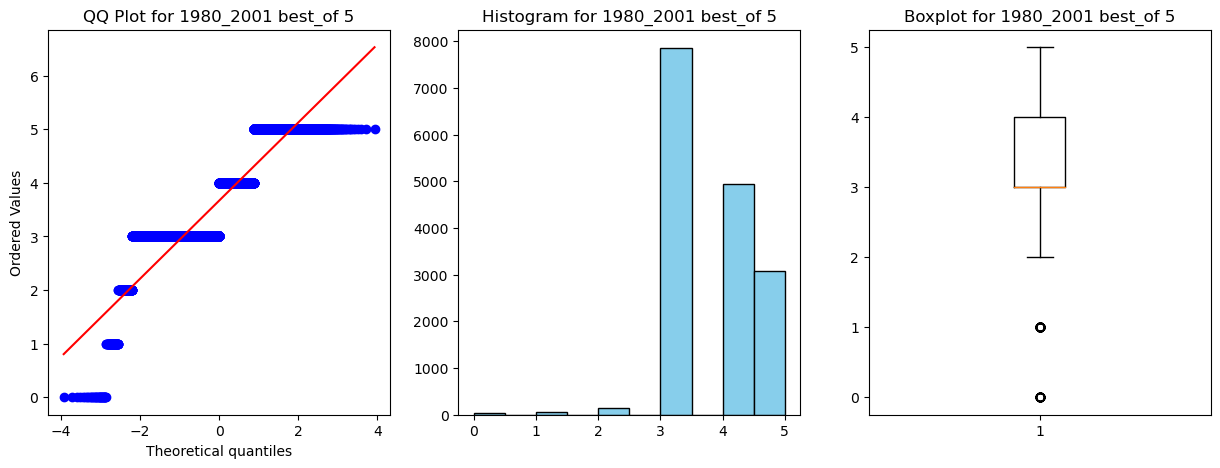

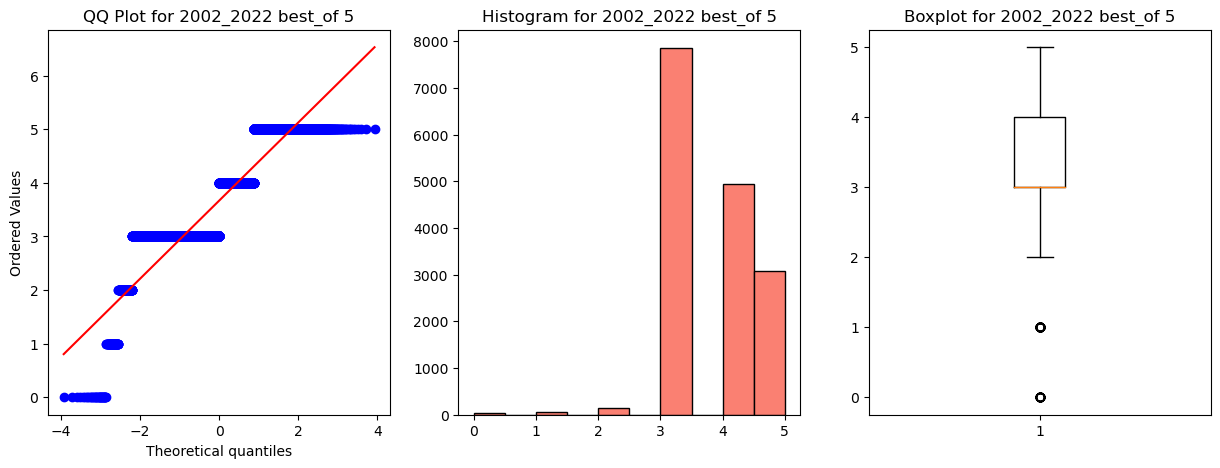

In [180]:
plot_comparison(group1_03_data.set_count, group1_03_data.set_count, title_a='1980_2001 best_of 5', title_b='2002_2022 best_of 5')

### Статистический тест на нормальность

In [181]:
shapiro_test(group1_03_data.set_count, group1_03_data.set_count, alpha=0.05)

alpha: 0.05
p-value sample A 0.0
p-value sample B 0.0
Отвергаем нулевую гипотезу H0: Распределения в обеих группах нормальные
Альтернативная гипотеза. H1: Распределение в одной или обеих группах отлично от нормального


> Допустим, что выборки все же нормально распределены, на основании графического представления. Поэтому используем Z-тест.

### Z - тест

In [182]:
# Нулевая гипотеза: среднее значение первой выборки меньше или равно среднему значению второй выборки
# Альтернативная гипотеза: среднее значение первой выборки больше среднего значения второй выборки

# Проведем z-тест
z_stat, p_value = ztest(group1_03_data.set_count, group1_03_data.set_count, alternative='larger')

print(f'Z-statistic: {z_stat}')
print(f'P-value: {p_value}')

# Установим уровень значимости, например, 0.05
alpha = 0.05

# Проверим нулевую гипотезу
if p_value < alpha:
    print("Отвергаем нулевую гипотезу - есть достаточные доказательства, что среднее первой выборки 1980_2001 больше среднего второй 2002_2023")
else:
    print("Не отвергаем нулевую гипотезу - нет достаточных доказательств считать среднее первой выборки 1980_2001 большим")

Z-statistic: 0.0
P-value: 0.5
Не отвергаем нулевую гипотезу - нет достаточных доказательств считать среднее первой выборки 1980_2001 большим


### Вывод:

>Графическое распределение говорит о нормальном распределении значений количества сетов в выборках.

>Проведенный z тест позволяет утверждать - среднее значение первой выборки 1980_2001 меньше или равно среднему значению второй выборки 2002_2022.

>Среднее количество сетов для любого игрока чтобы победить уменьшается со временем - не верно.

## 4.

> Вы хотите изучить психологическую устойчивость профессиональных игроков в теннис. Одним из важных показателей такой устойчивости будет доля выигранных брейк-поинтов. Возьмите трех игроков (они необязательно должны играть в одно и то же время. Можете взять игроков, которые сильно отличаются по рангу, а можете взять примерно равных игроков), для каждого из них посчитайте долю выигранных брейк поинтов (колонки, заканчивающиеся на bpFaced и bpSaved) отдельно в победных и проигранных матчах за минимум 10 лет (можно больше, но годы должны идти подряд). Постройте box-plot’ы для этих статистик для каждого из игроков. Являются ли эти распределения по годам (по победным и по проигранным матчам) независимыми для каждого из игроков? Если сравнивать эту статистику между игроками — будет ли разница в средних для проигранных и выигранных матчей значимой попарно между всеми игроками? Выбор статистического теста обоснуйте.

Для анализа психологической устойчивости профессиональных игроков в теннис и исследования доли выигранных брейк-поинтов в победных и проигранных матчах за минимум 10 лет для трех игроков, можно использовать следующий подход:

* Выбрать три профессиональных теннисиста, у которых есть достаточно данных о выигранных и проигранных матчах за последние 10 лет.
* Посчитать для каждого игрока долю выигранных брейк-поинтов в победных и проигранных матчах за каждый год из выбранного периода.
* Построить box-plot'ы для каждого игрока, отображающие распределение доли выигранных брейк-поинтов по годам для победных и проигранных матчей.
* Для каждого игрока проверить независимость распределений доли выигранных брейк-поинтов по годам для победных и проигранных матчей. Это можно сделать с помощью теста независимости, например, критерия хи-квадрат.
* Провести сравнение средних значений доли выигранных брейк-поинтов в победных и проигранных матчах между всеми игроками. Для этого можно использовать дисперсионный анализ (ANOVA) или непараметрические аналоги, такие как критерий Краскела-Уоллиса.
* Такой подход позволит оценить степень психологической устойчивости каждого игрока, а также сравнить их между собой по данной характеристике. Важно также учитывать возможные факторы, влияющие на результаты, такие как уровень игрока, типы соперников и турниров, а также изменения в рейтинге игрока.

 Выберите трех игроков с разным рангом или примерно равным уровнем игры.
- Для каждого игрока соберите данные о сыгранных матчах за период минимум 10 лет подряд. Данные должны включать количество брейк-поинтов, полученных игроком (bpFaced), и количество отыгранных брейк-поинтов (bpSaved) в каждом матче.
- Для каждого игрока разделите матчи на две группы: выигранные и проигранные.
- Посчитайте долю выигранных брейк-поинтов в каждой группе матчей за каждый год: Доля выигранных брейк-поинтов = bpSaved / bpFaced

In [ ]:
# Создание выборки к задаче
sample_04 = combined_df[['year', 'winner_id', 'loser_id', 'w_bpSaved', 'w_bpFaced', 'l_bpSaved', 'l_bpFaced', 'winner_rank', 'loser_rank']].dropna()

#Отбор трех игроков по количеству матчей что они сыграли
ids = list(sample_04.winner_id.value_counts().head(3).index)


# Данные по количеству сетов для группы 1 (1980-2001 гг.)
group1_03_data = sample_03[(sample_03['year'] >= 1980) & (sample_03['year'] <= 2001)].reset_index(drop=True)

# Данные по количеству сетов для группы 2 (2002-2022 гг.)
group2_03_data = sample_03[(sample_03['year'] >= 2002) & (sample_03['year'] <= 2022)].reset_index(drop=True)

# Вычисляем средние значения для обеих групп
mean_03_group1 = group1_03_data.set_count.mean()
mean_03_group2 = group2_03_data.set_count.mean()


# Сравнение среднего количества побед
print(f"Среднее количество сетов для побед в периоде 1980-2001: {mean_03_group1}")
print(f"Общее количество партий: {len(group1_03_data.set_count)}")
print(f"Среднее количество сетов для побед в периоде 2002-2022: {mean_03_group1}")
print(f"Общее количество партий: {len(group2_03_data.set_count)}")

### Выводы:

## 5.

> У вас есть гипотеза, что доля выигранных брейк-поинтов связана с вероятностью победить в игре. Соберите статистику, где для каждого матча будет собран его исход (победа/поражение) и доля выигранных брейк-поинтов (не забудьте, что в матче два игрока). Разделите долю выигранных брейкпоинтов на группы выше/ниже медианы и, используя информацию о исходе матча, проверьте зависимость между количеством выигранных брейкпоинтов и результатом матча. Насколько сильна эта зависимость? Выбор статистического теста обоснуйте.

### Вывод: